<a href="https://colab.research.google.com/github/Parkseojin2001/Hands-On-ML/blob/main/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1 MNIST

MNIST : 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕션너리 구조를 가지고 있다.

- 데이터셋을 설명하는 DESCR 키

- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키

- 레이블 배열을 담은 target 키

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있다. 그 이유는 28 x 28 픽셀이기 때문이다. 개개의 특성은 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

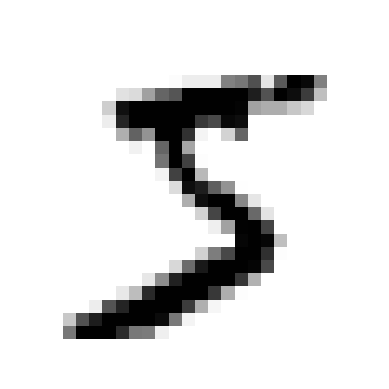

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

현재 레이블은 문자열이므로 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환해야한다.

In [ ]:
y = y.astype(np.uint8)

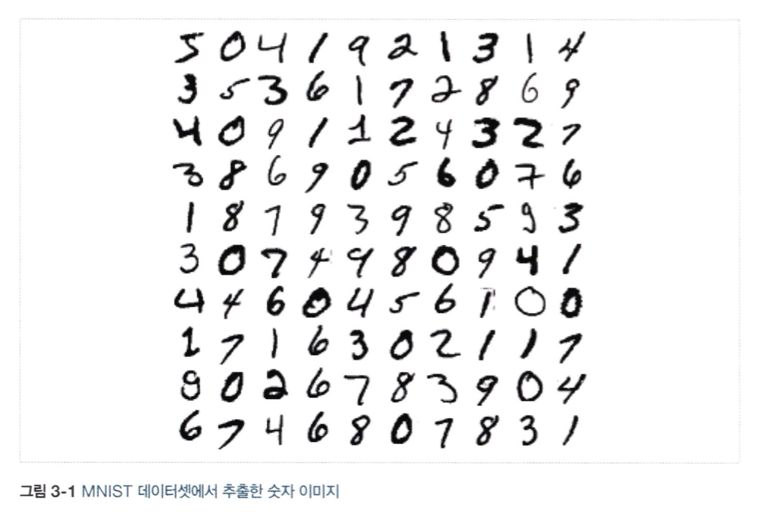

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

**이진 분류기** : 두 개의 클래스를 구분하는 분류기이다.

In [ ]:
# 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

**확률적 경사 하강법(SGD)**

- 사이킷런의 SGDClassifier 클래스를 사용

- 매우 큰 데이터셋을 효율적으로 처리하는 장접을 가지고 있다.

- 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 온라인 학습에 잘 들어맞다.

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

분류기 평가는 회귀 모델보다 훨씬 어렵다.

## 3.3.1 교차 검증을 사용한 정확도 측정

cross_val_score( ) 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가할 수 있다.

In [24]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

교차 검증 폴드에 대해  정확도가 95% 이상이다.

In [25]:
# 이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [26]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90% 이상으로 나왔으며 이미지의 10% 정도만 숫자 5로 인식한다.

**불균형한 데이터셋(어떤 클래스가 다른 것보다 월등히 많은 경우)**일 때 정확도를 분류기의 성능 측정 지표로 선호하지 않는다.

## 3.3.2 오차 행렬

**오차 행렬** : 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다.

ex. 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 &rarr; 오차 행렬의 5행 3열

> **오차 행렬 만들기**
>
> 실제 타깃과 비교할 수 있도록 먼저 예측값 만들어야 하며 테스트 세트로 예측을 만들어서는 안된다.

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

cross_val_score( ) 함수처럼 cross_val_predict( ) 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다.

**&rarr; 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다(훈련동안 보지 못했던 데이터에 대해 예측을 함).**

In [28]:
# confusion_matrix() 함수를 사용해 오차 행렬을 준비
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

첫 번째 행 : '5 아님' 이미지(**음성 클래스**)<br>
- 53,892개를 '5 아님'으로 정확히 분류(**진짜 음성**)<br>
- 687개는 '5'라고 잘못 분류(**거짓 양성**)

두 번째 행 : '5' 이미지(**양성 클래스**)<br>

- 1,891개를 '5 아님'으로 잘못 분류(**거짓 음성**)<br>
- 3,530개를 정확히 '5'로 분류(**진짜 양성**)

```
완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주 대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 된다.
```

In [31]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도** : 오차 행렬보다 요약되 지표가 필요할 때 사용

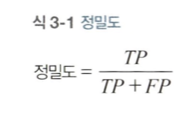

TP는 진짜 양성의 수이고, FP는 거짓 양성의 수이다.


**재현률** : 정밀도와 같이 사용하는 또 다른 지표로 분류기가 정확하게 감지한 양성 샘플의 비율로, **민감도** 또는 **진짜 양성 비율(TPR)**이라고 한다.

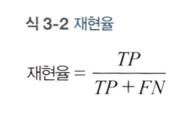

FN은 거짓 음성의 수이다.

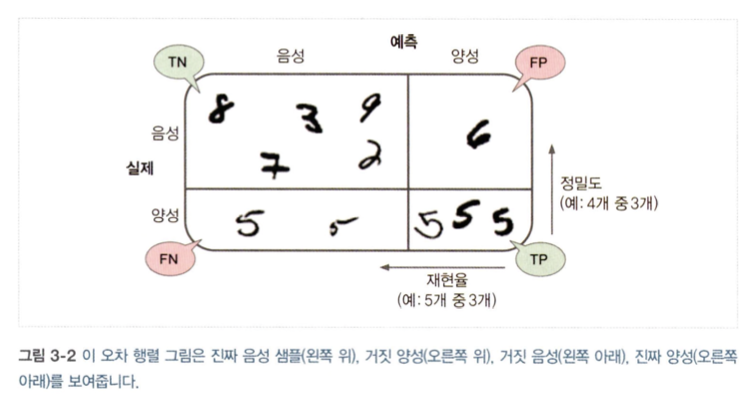

## 3.3.3 정밀도와 재현율

In [32]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

'5-감지기'가 정확도에서 봤을 때보다 성능이 떨어진다. <br>
- 5로 판별된 이미지 중 83.7%만 정확

- 전체 숫자 5에서 65.1%만 감지

**$F_1$ 점수** : 정빌도와 재현율을 하나의 숫자로 만든 수이며 이는 정밀도와 재현율의 **조화 평균**이다.

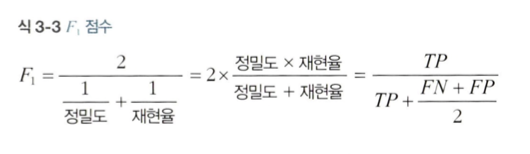


In [34]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 $F_1$가 높다.
*하지만, 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있으므로 $F_1$ 점수가 높은 것이 항상 바람직한 것은 아니다.*

```
ex. 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정
재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것이다.

ex. 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정
분류기의 재현율이 99%라면 정밀도가 30%만 되더라도 괜찮을 것이다.
```

**정밀도/재현율 트레이드오프** : 정밀도를 올리면 재현율이 줄고 그 반대도 만족한다.

## 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier 분류기는 **결정 함수**를 사용하여 각 샘플의 점수를 계산한다.

점수가 임계값보다 큰 경우 : 샘플을 양성 클래스에 할당

점수가 임계값보다 작은 경우 : 샘플을 음성 클래스에 할당

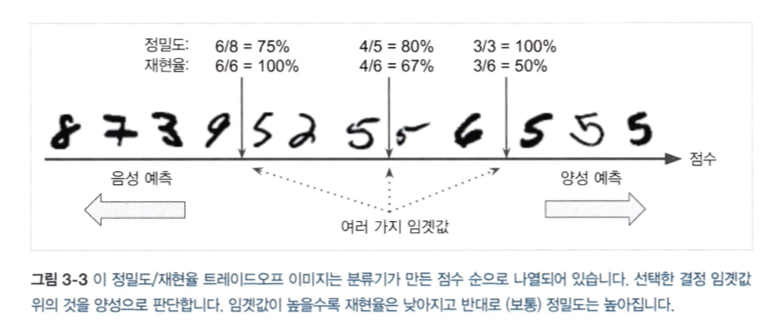

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.

분류기의 predict( ) 메서드 대신 decision_function( ) 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [38]:
# 임계값 높이기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [39]:
# cross_val_predict() 함수를 사용해 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [41]:
# precision_recall_curve() 함수를 통해 모든 임계값에 대해 정밀도와 재현율을 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

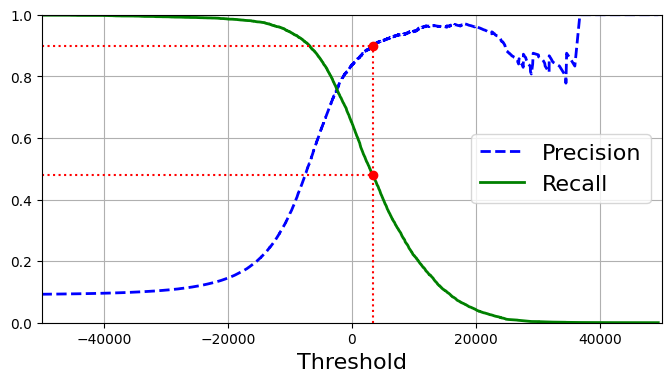

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.show()

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

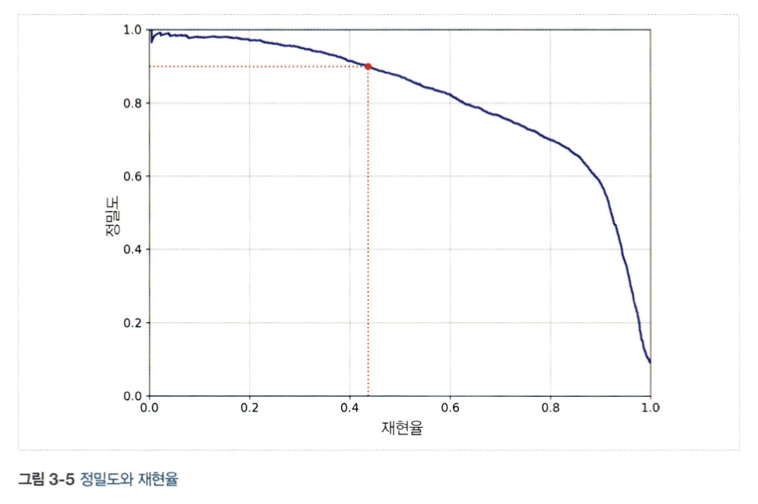

재현율 80%근처에서 정밀도가 급격하게 줄어들기 시작한다. 이 하강점 직전을 정밀도/재현율 트레이드 오프로 선택하는 것이 좋다.

**GOAL : 정밀도 90%를 달성**

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [49]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [50]:
# 정밀도와 재현율을 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [51]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

**수신기 조작 특성(ROC) 곡선** : 이진 분류에서 널리 사용하는 도구이다.

ROC곡선은 **거짓 양성 비율(FPR)**에 대한 **진짜 양성 비율(TPR, 재현율)**의 곡선이다.

FPR : 양성으로 잘못 분류된 음성 샘플의 비율, 1 - TNR(진짜 음성 비율, 특이도)

```
ROC 곡선은 민감도(재현율)에 대한 1 - 특이도 그래프이다.
```

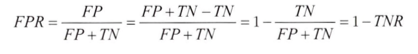

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

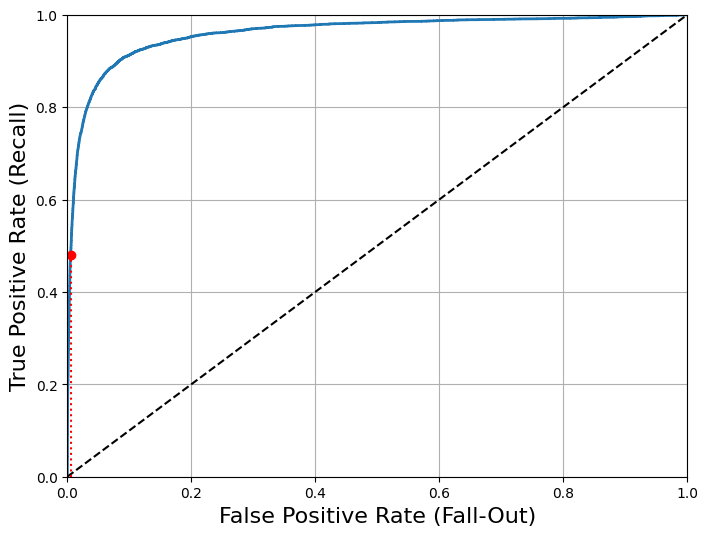

In [53]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다.

*좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다.(왼쪽 위 모서리)*

**곡선 아래의 면적(AUC)** : 이 면적을 통해 분류기들을 비교할 수 있다.

완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

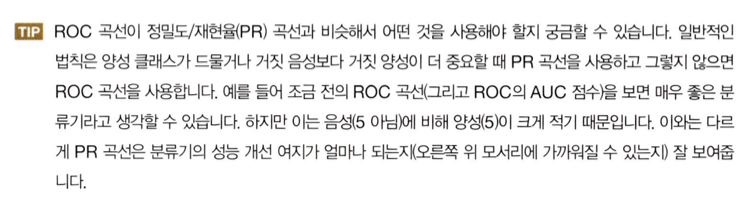

In [56]:
# RandomForestClassifier과 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = "predict_proba")

In [57]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

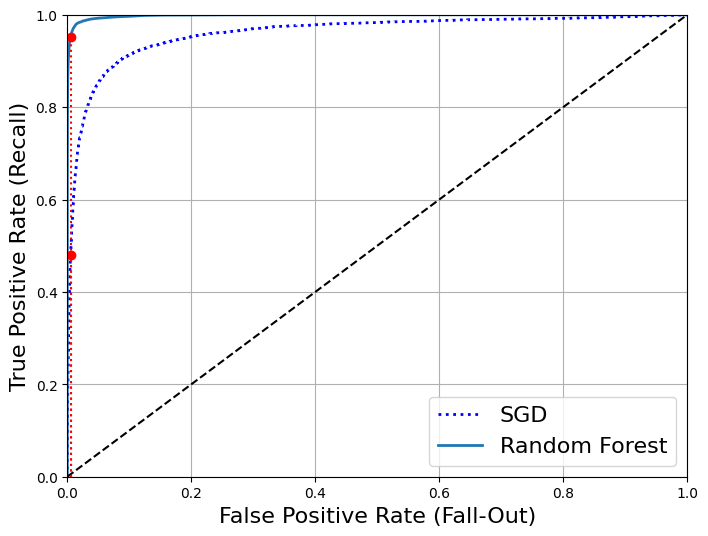

In [58]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

위의 그래프를 보면 RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 더 좋다. 당연히 ROC AUC 점수도 훨씬 높다.

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145